In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
SEED = 666

In [42]:
def draw_lineplot(x, y, title, 
                  figsize=(14,5), color='red',
                  xlabel='', ylabel=''):
    plt.figure(figsize=figsize)
    ax = sns.lineplot(x=x, y=y, color=color)
    ax.set(xlabel=xlabel, 
           ylabel=ylabel, 
           title=title)

In [43]:
def draw_seasonal(df, color='red', figsize=(14,5), 
                  need_trend=True, need_seasonal=True, 
                  need_resid=True):
    decomposed = seasonal_decompose(df)
    if need_trend:
        draw_lineplot(decomposed.trend.index, 
                           decomposed.trend, 'Тренд',
                           xlabel='Дата', ylabel='Количество заказов',
                           figsize=figsize)
    if need_seasonal:
        draw_lineplot(decomposed.seasonal.index, 
                      decomposed.seasonal, 'Сезонность', 
                      xlabel='Дата', ylabel='Количество заказов',
                      figsize=figsize)
    if need_resid:
        draw_lineplot(decomposed.resid.index, 
                      decomposed.resid, 'Остаток', 
                      xlabel='Дата', ylabel='Количество заказов',
                      figsize=figsize)

In [44]:
df = pd.read_csv('Airport.csv')

Дана информация о поссажиропотоке

In [45]:
df.sort_values(['Year', 'Month'], inplace=True)

In [46]:
df.head(15)

,Passengers,Year,Month
3,1575.27,2007,0
7,1956.15,2007,1
11,2365.56,2007,2
1,1487.53,2007,3
0,1235.75,2007,4
6,1587.49,2007,5
5,1875.66,2007,6
2,1563.96,2007,7
4,1762.00,2007,8
10,2066.34,2007,9


In [47]:
df.tail(15)

,Passengers,Year,Month
142,4542.83,2018,9
141,5247.11,2018,10
140,5893.07,2018,11
147,NaN,2019,0
151,NaN,2019,1
155,NaN,2019,2
145,NaN,2019,3
144,NaN,2019,4
150,NaN,2019,5
149,NaN,2019,6


Предскажим данные за последние 12 месяцев<br>
Выделим последние 12 значений в тестовую выборку

In [48]:
df['Month'] = df['Month'] + 1

In [49]:
df['date'] = df['Year'].astype(str) + '-' + df['Month'].astype(str)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')
df

,Passengers,Year,Month,date
3,1575.27,2007,1,2007-01-01
7,1956.15,2007,2,2007-02-01
11,2365.56,2007,3,2007-03-01
1,1487.53,2007,4,2007-04-01
0,1235.75,2007,5,2007-05-01
...,...,...,...,...
146,NaN,2019,8,2019-08-01
148,NaN,2019,9,2019-09-01
154,NaN,2019,10,2019-10-01
153,NaN,2019,11,2019-11-01


In [50]:
df.set_index(df['date'], inplace=True)
df.drop('date', axis=1, inplace=True)
df

,Passengers,Year,Month
date,,,
2007-01-01,1575.27,2007,1
2007-02-01,1956.15,2007,2
2007-03-01,2365.56,2007,3
2007-04-01,1487.53,2007,4
2007-05-01,1235.75,2007,5
...,...,...,...
2019-08-01,NaN,2019,8
2019-09-01,NaN,2019,9
2019-10-01,NaN,2019,10


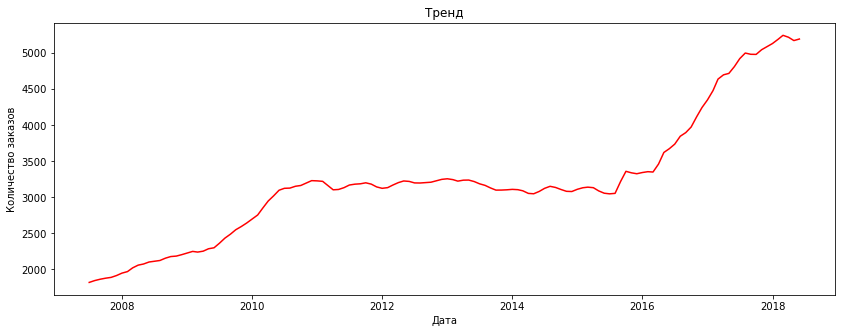

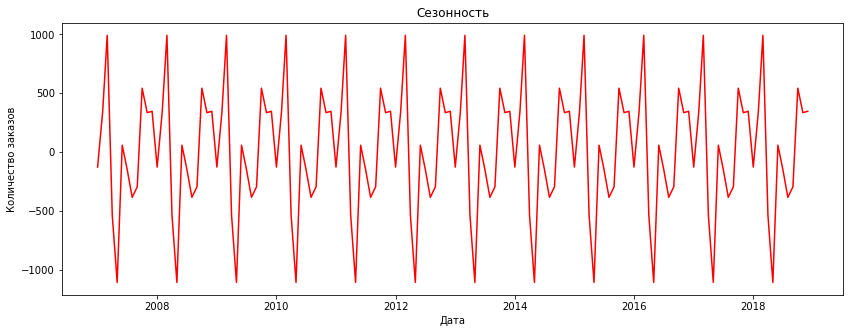

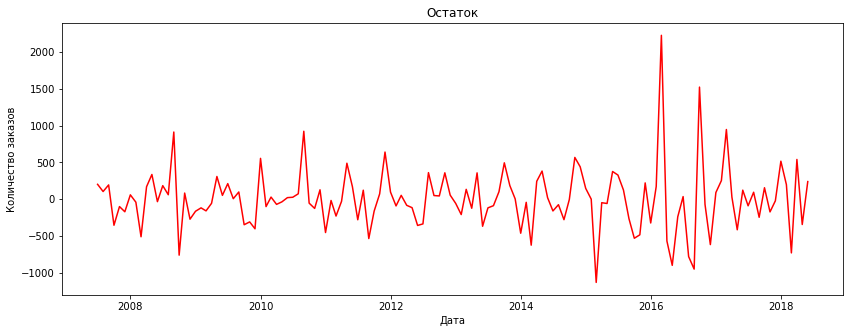

In [51]:
draw_seasonal(df['Passengers'].dropna())

In [52]:
def make_features(df, column, max_lag, rolling_mean_size):
    data = df.copy()
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    if rolling_mean_size != 0:
        data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()
    
    return data

In [53]:
df_test = df.query('Year == 2019')
df_test.drop('Passengers', axis=1, inplace=True)
#df_test.reset_index(drop=True, inplace=True)
df_test

/Users/pavelpankov/miniforge3/envs/base_env/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Year,Month
date,,
2019-01-01,2019,1
2019-02-01,2019,2
2019-03-01,2019,3
2019-04-01,2019,4
2019-05-01,2019,5
2019-06-01,2019,6
2019-07-01,2019,7
2019-08-01,2019,8
2019-09-01,2019,9


Отлично, пойдём дальше. Уберём из данных выделенное

In [54]:
df_train = df.query('Year < 2019')
df_train

,Passengers,Year,Month
date,,,
2007-01-01,1575.27,2007,1
2007-02-01,1956.15,2007,2
2007-03-01,2365.56,2007,3
2007-04-01,1487.53,2007,4
2007-05-01,1235.75,2007,5
...,...,...,...
2018-08-01,5558.45,2018,8
2018-09-01,4936.49,2018,9
2018-10-01,4542.83,2018,10


In [55]:
df_features = make_features(df_train, column='Passengers', max_lag=5, rolling_mean_size=0)
df_features.dropna(inplace=True)

In [56]:
df_features

,Passengers,Year,Month,lag_1,lag_2,lag_3,lag_4,lag_5
date,,,,,,,,
2007-06-01,1587.49,2007,6,1235.75,1487.53,2365.56,1956.15,1575.27
2007-07-01,1875.66,2007,7,1587.49,1235.75,1487.53,2365.56,1956.15
2007-08-01,1563.96,2007,8,1875.66,1587.49,1235.75,1487.53,2365.56
2007-09-01,1762.00,2007,9,1563.96,1875.66,1587.49,1235.75,1487.53
2007-10-01,2066.34,2007,10,1762.00,1563.96,1875.66,1587.49,1235.75
...,...,...,...,...,...,...,...,...
2018-08-01,5558.45,2018,8,5226.89,5493.41,3722.28,5222.28,5509.70
2018-09-01,4936.49,2018,9,5558.45,5226.89,5493.41,3722.28,5222.28
2018-10-01,4542.83,2018,10,4936.49,5558.45,5226.89,5493.41,3722.28


Удалим из выборок столбец с годом, он нам не понадобится

In [57]:
#df_train.drop('Year', axis=1, inplace=True)
#df_test.drop('Year', axis=1, inplace=True)
#display(df_train)
#df_features.drop('Year', axis=1, inplace=True)
display(df_features)
display(df_test)

,Passengers,Year,Month,lag_1,lag_2,lag_3,lag_4,lag_5
date,,,,,,,,
2007-06-01,1587.49,2007,6,1235.75,1487.53,2365.56,1956.15,1575.27
2007-07-01,1875.66,2007,7,1587.49,1235.75,1487.53,2365.56,1956.15
2007-08-01,1563.96,2007,8,1875.66,1587.49,1235.75,1487.53,2365.56
2007-09-01,1762.00,2007,9,1563.96,1875.66,1587.49,1235.75,1487.53
2007-10-01,2066.34,2007,10,1762.00,1563.96,1875.66,1587.49,1235.75
...,...,...,...,...,...,...,...,...
2018-08-01,5558.45,2018,8,5226.89,5493.41,3722.28,5222.28,5509.70
2018-09-01,4936.49,2018,9,5558.45,5226.89,5493.41,3722.28,5222.28
2018-10-01,4542.83,2018,10,4936.49,5558.45,5226.89,5493.41,3722.28


,Year,Month
date,,
2019-01-01,2019,1
2019-02-01,2019,2
2019-03-01,2019,3
2019-04-01,2019,4
2019-05-01,2019,5
2019-06-01,2019,6
2019-07-01,2019,7
2019-08-01,2019,8
2019-09-01,2019,9


Выделим у обучающих данных целевой признак 

In [58]:
#X = df_train.drop(['Passengers'], axis=1)
#y = df_train['Passengers']
X = df_features.drop(['Passengers'], axis=1)
y = df_features['Passengers']

In [59]:
X

,Year,Month,lag_1,lag_2,lag_3,lag_4,lag_5
date,,,,,,,
2007-06-01,2007,6,1235.75,1487.53,2365.56,1956.15,1575.27
2007-07-01,2007,7,1587.49,1235.75,1487.53,2365.56,1956.15
2007-08-01,2007,8,1875.66,1587.49,1235.75,1487.53,2365.56
2007-09-01,2007,9,1563.96,1875.66,1587.49,1235.75,1487.53
2007-10-01,2007,10,1762.00,1563.96,1875.66,1587.49,1235.75
...,...,...,...,...,...,...,...
2018-08-01,2018,8,5226.89,5493.41,3722.28,5222.28,5509.70
2018-09-01,2018,9,5558.45,5226.89,5493.41,3722.28,5222.28
2018-10-01,2018,10,4936.49,5558.45,5226.89,5493.41,3722.28


In [60]:
y

date
2007-06-01    1587.49
2007-07-01    1875.66
2007-08-01    1563.96
2007-09-01    1762.00
2007-10-01    2066.34
               ...   
2018-08-01    5558.45
2018-09-01    4936.49
2018-10-01    4542.83
2018-11-01    5247.11
2018-12-01    5893.07
Name: Passengers, Length: 139, dtype: float64

Разобъём на обучающую и тестовую выборки

In [61]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=SEED)

Подготовим функции для упрощения работы

In [62]:
def test_model(model, X, y, X_test, y_test):
    model.fit(X, y)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    #print(mse)
    return mse

Проверим линейную регрессию

In [63]:
test_model(LinearRegression(), train_X, train_y, test_X, test_y)

272981.1225303537

Требуемое mse должно быть не больше 520 000, у нас 1 067 683 - перебор. Пробуем другие модели

In [64]:
best_mse = 1000000
best_depth = 0
for depth in range(1, 20, 1):
    mse = test_model(DecisionTreeRegressor(random_state=SEED, max_depth=depth), 
                     train_X, train_y, test_X, test_y)
    if mse < best_mse:
        best_mse = mse
        best_depth = depth
        
print(best_mse)
print(best_depth)

393115.9215884189
3


Лучше, 921 458, но всё равно мало

In [65]:
#best_mse = 1000000
#best_depth = 0
#best_est = 0
#for depth in range(1, 20, 1):
#    for est in range (100, 2000, 100):
#        mse = test_model(RandomForestRegressor(random_state=SEED, max_depth=5, n_estimators=est), 
#                         train_X, train_y, test_X, test_y)
#        if mse < best_mse:
#            best_mse = mse
#            best_depth = depth 
#            best_est = est

#print(best_mse)
#print(best_depth)
#print(best_est)

Ещё чуть лучше - 956 723<br>
Идём дальше

In [66]:
df_test

,Year,Month
date,,
2019-01-01,2019,1
2019-02-01,2019,2
2019-03-01,2019,3
2019-04-01,2019,4
2019-05-01,2019,5
2019-06-01,2019,6
2019-07-01,2019,7
2019-08-01,2019,8
2019-09-01,2019,9


In [67]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [68]:
for i in range(0, 12):
    row = df_test[i:i+1]
    df_train = df_train.append(row)
    df_features = make_features(df_train, column='Passengers', max_lag=5, rolling_mean_size=0)
    X_test = df_features.tail(1).drop(['Passengers'], axis=1)
    predictions = model.predict(X_test)
    df_train.tail(1)['Passengers'] = predictions[0]
    
df_train

/var/folders/_k/mz42v2vs1cl9r_2189kkdycm0000gn/T/ipykernel_48075/1331911851.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.tail(1)['Passengers'] = predictions[0]
/var/folders/_k/mz42v2vs1cl9r_2189kkdycm0000gn/T/ipykernel_48075/1331911851.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.tail(1)['Passengers'] = predictions[0]
/var/folders/_k/mz42v2vs1cl9r_2189kkdycm0000gn/T/ipykernel_48075/1331911851.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

,Passengers,Year,Month
date,,,
2007-01-01,1575.270000,2007,1
2007-02-01,1956.150000,2007,2
2007-03-01,2365.560000,2007,3
2007-04-01,1487.530000,2007,4
2007-05-01,1235.750000,2007,5
...,...,...,...
2019-08-01,5057.569331,2019,8
2019-09-01,5042.027126,2019,9
2019-10-01,5216.562026,2019,10


In [69]:
df_train['Passengers'] = df_train['Passengers'].astype(int)

In [70]:
df_train.tail(12)

,Passengers,Year,Month
date,,,
2019-01-01,4737,2019,1
2019-02-01,4518,2019,2
2019-03-01,5038,2019,3
2019-04-01,5041,2019,4
2019-05-01,4689,2019,5
2019-06-01,4789,2019,6
2019-07-01,5052,2019,7
2019-08-01,5057,2019,8
2019-09-01,5042,2019,9


In [71]:
X_test = df_features.tail(1).drop(['Passengers'], axis=1)

In [72]:
predictions = model.predict(X_test)
predictions

array([5481.7494709])

In [73]:
df_features.tail(1)['Passengers'] = predictions[0]
df_features

/var/folders/_k/mz42v2vs1cl9r_2189kkdycm0000gn/T/ipykernel_48075/1846752448.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features.tail(1)['Passengers'] = predictions[0]


,Passengers,Year,Month,lag_1,lag_2,lag_3,lag_4,lag_5
date,,,,,,,,
2007-01-01,1575.270000,2007,1,NaN,NaN,NaN,NaN,NaN
2007-02-01,1956.150000,2007,2,1575.270000,NaN,NaN,NaN,NaN
2007-03-01,2365.560000,2007,3,1956.150000,1575.270000,NaN,NaN,NaN
2007-04-01,1487.530000,2007,4,2365.560000,1956.150000,1575.270000,NaN,NaN
2007-05-01,1235.750000,2007,5,1487.530000,2365.560000,1956.150000,1575.270000,NaN
...,...,...,...,...,...,...,...,...
2019-08-01,5057.569331,2019,8,5052.324088,4789.925640,4689.681725,5041.296374,5038.023509
2019-09-01,5042.027126,2019,9,5057.569331,5052.324088,4789.925640,4689.681725,5041.296374
2019-10-01,5216.562026,2019,10,5042.027126,5057.569331,5052.324088,4789.925640,4689.681725
